In [1]:
import numpy as np
import vertex_cover
import dwave.inspector
import matplotlib.pyplot as plt
import networkx as nx
import dwave_networkx as dnx
from collections import defaultdict
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod.reference.samplers import ExactSolver

In [23]:
################ Select where to run : 1 for local, 2 for cloud ################

solver_location = 2
token = # set token here #

Problem Size :  10 , Running :  on cloud
	Solution size (Classical) :  6
	Solution size (Quantum) :  4
	Solution size (Reference) :  4

	Classical Solution is a valid cover :  True
	Quantum Solution is a valid cover :  True
	Exact Solution is a valid cover :  True

**************************************************************************

Problem Size :  20 , Running :  on cloud
	Solution size (Classical) :  14
	Solution size (Quantum) :  9
	Solution size (Reference) :  9

	Classical Solution is a valid cover :  True
	Quantum Solution is a valid cover :  True
	Exact Solution is a valid cover :  True

**************************************************************************

Problem Size :  30 , Running :  on cloud
	Solution size (Classical) :  22
	Solution size (Quantum) :  13
	Solution size (Reference) :  13

	Classical Solution is a valid cover :  True
	Quantum Solution is a valid cover :  True
	Exact Solution is a valid cover :  True

**********************************************

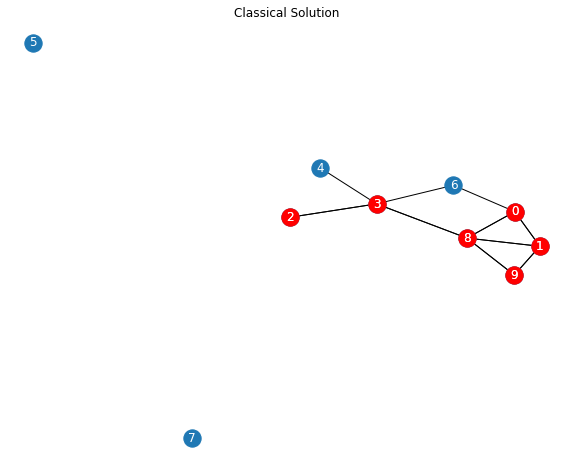

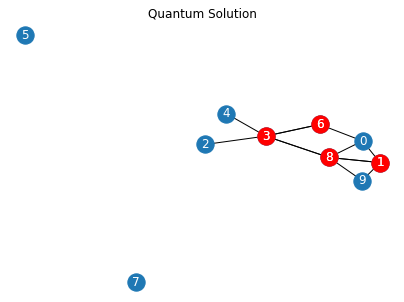

In [26]:
################ Main body of the program ################

vertex_cover_classical = []
vertex_cover_quantum = []
vertex_cover_exact = []

size_classical = []
size_quantum = []
size_exact = []

dwave_samplesets = []

if solver_location == 1:
    sizes = [3, 5, 8, 10, 15, 20, 22, 23, 25]
    sampler = ExactSolver()
    running = 'locally'
else:
    sizes = [10, 20, 30, 40, 50, 100, 150, 200, 300, 500]
    sampler = EmbeddingComposite(DWaveSampler(token=token, solver=dict(qpu=True)))
    running = 'on cloud'

for i, size in enumerate(sizes):
    print("Problem Size : ", size, ", Running : ", running)
    G = nx.gnm_random_graph(size, size, seed=42)
    h = defaultdict(int)
    J = defaultdict(int)
    penalty = 2

    ################ Classical Algorithm ################

    adjacency = np.array(nx.adjacency_matrix(G).todense())
    vc = vertex_cover.VertexCover(adjacency)
    cover_size, cover_classical, time = vc.get_vertex_cover()

    print("\tSolution size (Classical) : ", len(cover_classical))

    size_classical.append(cover_size)
    vertex_cover_classical.append(cover_classical)

    ################ Quantum Algorithm ################

    for u, v in G.edges:
        J[(u,v)] += penalty

    for e in G.nodes:
        h[e] += (1 - G.degree[e] * penalty)
    
    sampleset = sampler.sample_ising(h=h, J=J, num_reads=100, label='minimum-vertex-cover')
    dwave_samplesets.append(sampleset)
    cover_quantum = [k for k,v in sampleset.first.sample.items() if v == 1]

    print("\tSolution size (Quantum) : ", len(cover_quantum))

    size_quantum.append(len(cover_quantum))
    vertex_cover_quantum.append(cover_quantum)    

    ################ Reference solution using DWave's implementation of the problem ################

    cover_exact = dnx.min_vertex_cover(G, sampler)
    
    print("\tSolution size (Reference) : ", len(cover_exact))

    vertex_cover_exact.append(cover_exact)
    size_exact.append(len(cover_exact))

    ################ Verify if quantum and classical solutions are valid covers ################

    print("")
    print("\tClassical Solution is a valid cover : ", dnx.is_vertex_cover(G, cover_classical))
    print("\tQuantum Solution is a valid cover : ", dnx.is_vertex_cover(G, cover_quantum))
    print("\tExact Solution is a valid cover : ", dnx.is_vertex_cover(G, cover_exact))
    print("")
    print("**************************************************************************")
    print("")

    ################ Print an example graph with covers ################

    if i == 0:
        plt.figure(figsize=(10,8))
        ax = plt.gca()
        ax.set_title('Classical Solution')
        _ = ax.axis('off')
        pos = nx.spring_layout(G, seed=42)
        nx.draw_networkx(G, pos=pos, with_labels=True, font_color='white')
        nx.draw_networkx(G.subgraph(cover_classical), pos=pos, node_color='red', font_color='white')
        plt.savefig('Classical Solution')

        plt.figure(figsize=(7,5))
        ax = plt.gca()
        ax.set_title('Quantum Solution') 
        _ = ax.axis('off')       
        nx.draw_networkx(G, pos=pos, with_labels=True, font_color='white')
        nx.draw_networkx(G.subgraph(cover_quantum), pos=pos, node_color='red', font_color='white')
        plt.savefig('Quantum Solution')
        

In [29]:
############### Inspect solution data, when running on the QPU ###############

dwave.inspector.show(dwave_samplesets[0])

'http://127.0.0.1:18000/?problemId=2eb82af5-30b1-4c23-b546-df2011cfcc7a'

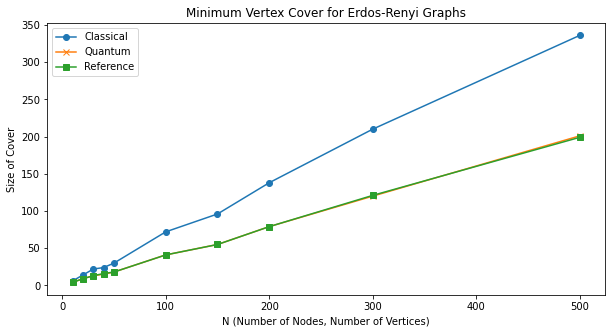

In [27]:
############### Comparison of estimated cover sizes ###############

plt.figure(figsize=(10,5))
plt.plot(sizes, size_classical, marker='o', label='Classical')
plt.plot(sizes, size_quantum, marker='x', label='Quantum')
plt.plot(sizes, size_exact, marker='s', label='Reference')
plt.xlabel('N (Number of Nodes, Number of Vertices)')
plt.ylabel('Size of Cover')
plt.title('Minimum Vertex Cover for Erdos-Renyi Graphs')
plt.legend()
plt.savefig('solution-size-analysis.png')